In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
!pip install torchaudio

     |████████████████████████████████| 1.9MB 8.3MB/s 


In [3]:
import opendatasets as od
dataset_url = "https://www.kaggle.com/chrisfilo/urbansound8k"
od.download(dataset_url)

  0%|          | 5.00M/5.61G [00:00<02:11, 45.8MB/s]

100%|██████████| 5.61G/5.61G [02:00<00:00, 49.9MB/s]


In [4]:
from urbansounddataset_colab import UrbanSoundDataset

import torch
import pickle
import torchaudio
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import os
from torchsummary import summary
from torchvision.utils import make_grid
from torch.utils.data import random_split
from tqdm import tqdm
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import time
from tqdm.notebook import tqdm
%matplotlib inline

In [5]:
import pandas as pd
df = pd.read_csv("urbansound8k/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
ANNOTATIONS_FILE = "urbansound8k/UrbanSound8K.csv"
AUDIO_DIR = "urbansound8k"


#ANNOTATIONS_FILE = "E:\\codes\\Machine_learning\\deep_learning\\audio\\urban-sound-git\\urban-audio-classifier\\UrbanSound8K\\metadata\\UrbanSound8K.csv"
#AUDIO_DIR = "E:\\codes\\Machine_learning\\deep_learning\\audio\\urban-sound-git\\urban-audio-classifier\\UrbanSound8K\\audio"
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050


mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=1024,
            hop_length=512,
            n_mels=64
        )


In [7]:
usd = UrbanSoundDataset(ANNOTATIONS_FILE,
                             AUDIO_DIR,
                             mel_spectrogram,
                             SAMPLE_RATE,
                             NUM_SAMPLES)

In [8]:
signal, label = usd[0]
signal.shape , label

(torch.Size([1, 64, 44]), 3)

In [9]:
total_count = len(usd)

print(f"Total data : {total_count}")

train_count = int(0.7*total_count)
valid_count = int(0.2*total_count)
test_count = total_count-train_count-valid_count

train_dataset , valid_dataset , test_dataset = random_split(usd,(train_count,valid_count,test_count))
print("Train data : ",train_count)
print("Valid data : ",valid_count)
print("Test data : ", test_count)

Total data : 8732
Train data :  6112
Valid data :  1746
Test data :  874


In [10]:

def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    
    if isinstance(data, (list, tuple)):
        return [to_device(x , device ) for x in data]
    return data.to(device , non_blocking = True)


class DeviceDataLoader():
    
    def __init__(self, dl, device):
        
        self.dl = dl 
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
# creating data loader : 
BATCH_SIZE = 128

train_dl = DeviceDataLoader(DataLoader(train_dataset,batch_size = BATCH_SIZE, shuffle = True,num_workers=2,pin_memory=True ),device)
valid_dl = DeviceDataLoader(DataLoader(valid_dataset,batch_size = BATCH_SIZE, shuffle = True ,num_workers=2,pin_memory=True), device)
test_dl = DeviceDataLoader(DataLoader(test_dataset,batch_size = BATCH_SIZE, shuffle = False,num_workers=2,pin_memory=True),device)

In [13]:
for signal, label in train_dl:
    print(signal.shape)
    break
    

torch.Size([128, 1, 64, 44])


In [14]:
for signal, label in valid_dl:
    print(signal.shape)
    break

torch.Size([128, 1, 64, 44])


In [15]:
class SoundClassificationBase(nn.Module):
    
    def training_step(self, batch):
        signals , labels  = batch
        output = self(signals) # generates output
        loss = F.cross_entropy(output, labels) # generates loss
        return loss
    
    def validation_step(self, batch):
        signals, labels = batch
        output = self(signals)  # generates output
        loss = F.cross_entropy(output, labels) # generates loss on validation step 
        acc = accuracy(output, labels) # generates accuracy on validation set 
        return {"val_acc": acc, "val_loss": loss}
    
    def validation_epoch_end(self, output):
        batch_loss = [x['val_loss'] for x in output]
        epoch_loss = torch.stack(batch_loss).mean() # combine losses
        batch_acc = [x['val_acc'] for x in output]
        epoch_acc = torch.stack(batch_acc).mean()  # combine accurecies
        
        return {"val_acc": epoch_acc.item(), "val_loss": epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch[{epoch}] , train loss : {result['train_loss']:.3f} ,val loss : {result['val_loss']:.3f} , val accuracy : {result['val_acc']:.3f}")
        
        # open_file = open(saved_result, 'wb')
        # pickle.dump(result,open_file)
        # open_file.close()

        
def accuracy(output, labels):
    _ , preds = torch.max(output, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [16]:
class UsdCnnModel(SoundClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        
        self.network = nn.Sequential(
            
            
            # input 1 x 64 x 44
            nn.Conv2d(1,16, kernel_size = 3, stride = 1, padding = 2), # input size =16 x 66 x 46
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2), # 16 x 33 x 23
            
            nn.Conv2d(16, 32, kernel_size=3, stride = 1, padding = 2), # 32 x 35 x 25
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # output 32 x 17 x 12
            
            
            nn.Conv2d(32, 64 , kernel_size=3, stride = 1, padding = 2), # 64 x 19 x 14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # 64 x 9 x 7


            nn.Conv2d(64 , 128 , kernel_size= 3 , stride = 1 , padding = 2), # 128 x 11 x  9
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.MaxPool2d(2), # output 128 x 5 x 4
            
            
            nn.Flatten(),
            nn.Linear(128*5*4, 10),
            nn.Softmax(dim=1))

        
    def forward(self, xb):
        return self.network(xb)
    
        
        

In [17]:
for signal, label in train_dl:
    print(signal.shape)
    break
    

torch.Size([128, 1, 64, 44])


In [18]:
model = to_device(UsdCnnModel(),device)
print("*"*25+" Model Summary "+"*"*25)
print(summary(model,(1,64,44) ))

************************* Model Summary *************************
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 66, 46]             160
       BatchNorm2d-2           [-1, 16, 66, 46]              32
              ReLU-3           [-1, 16, 66, 46]               0
         MaxPool2d-4           [-1, 16, 33, 23]               0
            Conv2d-5           [-1, 32, 35, 25]           4,640
       BatchNorm2d-6           [-1, 32, 35, 25]              64
              ReLU-7           [-1, 32, 35, 25]               0
         MaxPool2d-8           [-1, 32, 17, 12]               0
            Conv2d-9           [-1, 64, 19, 14]          18,496
      BatchNorm2d-10           [-1, 64, 19, 14]             128
             ReLU-11           [-1, 64, 19, 14]               0
        MaxPool2d-12             [-1, 64, 9, 7]               0
           Conv2d-13           [-1, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [19]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [20]:
@torch.no_grad()
def evalute(model,val_loader):
    model.eval()
    
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)




def fit(start_epoch, epochs, lr, model,history, train_loader, valid_loader , optimizer):

    
    
    
    start = time.time()
    for epoch in tqdm(range(start_epoch,epochs)):
        
        # training phase 
        model.train()
        train_losses = []
        
        for batch in train_loader: 
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            optimizer.step()
            
            optimizer.zero_grad()
            
        
        # validation phase 
        
        result = evalute(model, valid_loader)
        result["train_loss"]  = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        # saving history to drive 
        open_file = open(saved_history, 'wb')
        pickle.dump(history,open_file)
        open_file.close()
        
        # saving the model
        
        #saving model in drive
        model_save_name = 'urban_sound_classification_mel_spec_cnn_softmax.pt'
        saving_path = F"/content/drive/MyDrive/DL_models/UrbanSound8k/{model_save_name}" 
        #saving_path = F"data/{model_save_name}" 

        
        torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),


                    }, saving_path)
        end = time.time()
        print((end-start)/60,' Minutes')
    
    return history

In [21]:
evalute(model, valid_dl)

{'val_acc': 0.11578560620546341, 'val_loss': 2.3155293464660645}

In [22]:
lr = 0.001
total_epochs = 50
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

In [23]:
start_epoch = 0
#history = [] #uncomment this only on first time running (if saved_history.pkl doesn't exist )
saved_history = "/content/drive/MyDrive/DL_models/UrbanSound8k/saved_history.pkl" 
checkpoint = torch.load("/content/drive/MyDrive/DL_models/UrbanSound8k/urban_sound_classification_mel_spec_cnn_softmax.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

open_file = open(saved_history, "rb")
history = pickle.load(open_file)
open_file.close()


In [24]:
complete_history = fit(start_epoch,total_count,lr,model,history,train_dl,valid_dl,optimizer)

Epoch[93] , train loss : 1.647 ,val loss : 1.950 , val accuracy : 0.507
2.9063095609347025  Minutes
Epoch[94] , train loss : 1.649 ,val loss : 1.880 , val accuracy : 0.576
5.676251292228699  Minutes
Epoch[95] , train loss : 1.646 ,val loss : 1.986 , val accuracy : 0.472
8.223115078608195  Minutes


KeyboardInterrupt: ignored

In [25]:
open_file = open(saved_history, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

len(loaded_list), type(loaded_list)

(86, list)

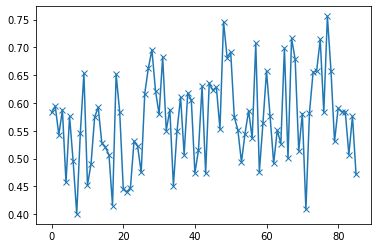

In [43]:
import matplotlib.pyplot as plt


val_accuracies = [x['val_acc'] for x in loaded_list]
plt.plot(val_accuracies,'-x')

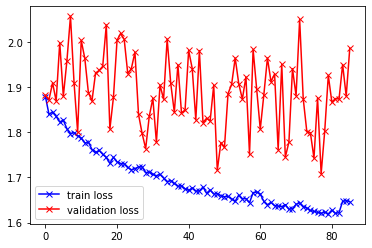

In [64]:
train_losses = [x['train_loss'] for x in loaded_list]
val_losses = [x['val_loss'] for x in loaded_list]

plt.plot(train_losses,'-bx')
plt.plot(val_losses,'-rx')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [45]:
class_mapping = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
]
def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected


In [60]:
input, target = usd[22][0], usd[22][1]
input.unsqueeze_(0)

predicted, expected = predict(model.cpu(), input, target,class_mapping)
print(f"Predicted: '{predicted}', expected: '{expected}'")

Predicted: 'air_conditioner', expected: 'air_conditioner'
